### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [74]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
def draw_ellipse(mu, C, scales, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    
    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,facecolor='none',edgecolor='k',
                          **kwargs))
    

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.mixture import GaussianMixture
import matplotlib.patches as mpatches

In [76]:
#1 Loading the Information
info = np.load('./hw_data/hw6_data_1.npy') 

In [77]:
#Gaining the Data
x = info[:,0]
y = info[:,1]
label = info[:,2]
X = np.transpose([x, y])

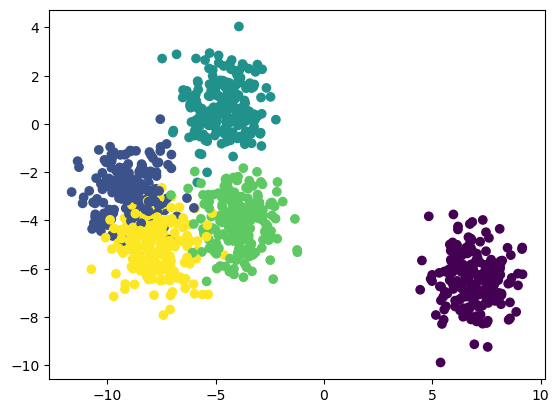

In [78]:
plt.scatter(x,y, c = label)

0.4724137931034482 Is the Optimal Bandwidth


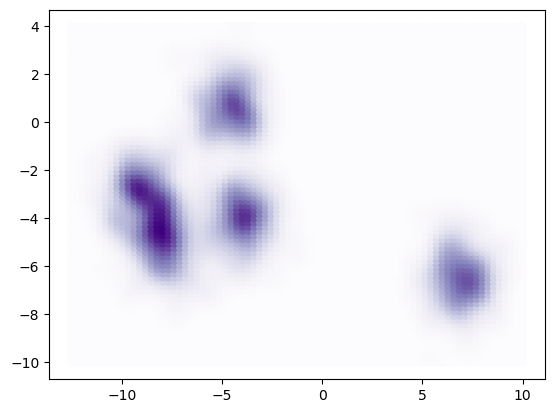

In [79]:
#2
#Finding the optimal bandwidth
bwrange = np.linspace(0.1, 1, 30) # Test 30 bandwidths from 0.1 to 1.0
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=5) 
grid.fit(X) 
param = grid.best_params_['bandwidth']
print(param, "Is the Optimal Bandwidth")

#Fitting the function
kde = KernelDensity(kernel='gaussian', bandwidth=param)
kde.fit(X) 

#Plotting Function
u = np.linspace(-12.5,10,80)
v = np.linspace(-10,4,80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c = dens, cmap="Purples", edgecolor="None")

Text(5, 3, 'n_neighbors=2')

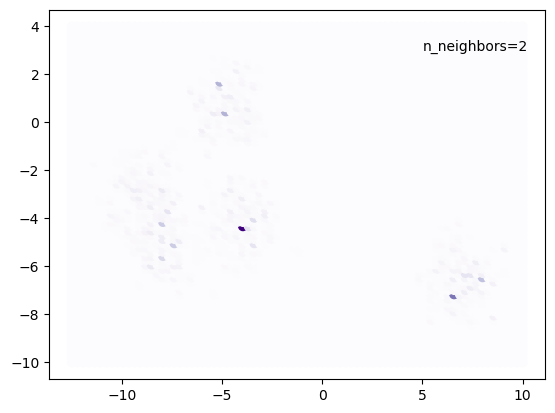

In [80]:
#3
t = np.array([np.linspace(-12.5,10,500),np.linspace(-10,10,500)]).T #Set a 2d Array for neighbors 
nbrs = KNeighborsDensity('bayesian', n_neighbors=2) #Start Small for bad example
nbrs.fit(X)
dens_nbrs = nbrs.eval(Xgrid)
plt.scatter(Xgrid[:,0],Xgrid[:,1], c = dens_nbrs, cmap="Purples")
plt.text(5,3,"n_neighbors=2")

Text(0.5, 1.0, 'KNN')

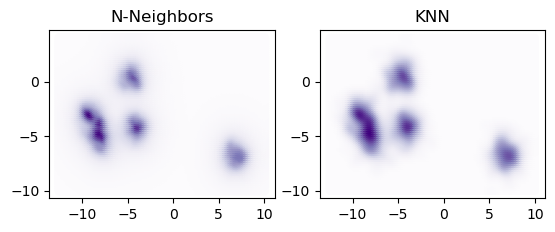

In [81]:
#3 cont.
n = 50 # This gets a good thing
nbrs = KNeighborsDensity('bayesian', n_neighbors=n)
nbrs.fit(X)
dens_nbrs = nbrs.eval(Xgrid)
plt.subplot(2, 2, 1)
plt.scatter(Xgrid[:,0],Xgrid[:,1], c = dens_nbrs, cmap="Purples")
plt.title("N-Neighbors")
plt.subplot(2, 2, 2)
plt.scatter(Xgrid[:,0], Xgrid[:,1], c = dens, cmap="Purples", edgecolor="None")
plt.title("KNN")


See that these are similar looking at a very high number of neighbors

4 Optimal components for BIC
5 Optimal componenets for AIC


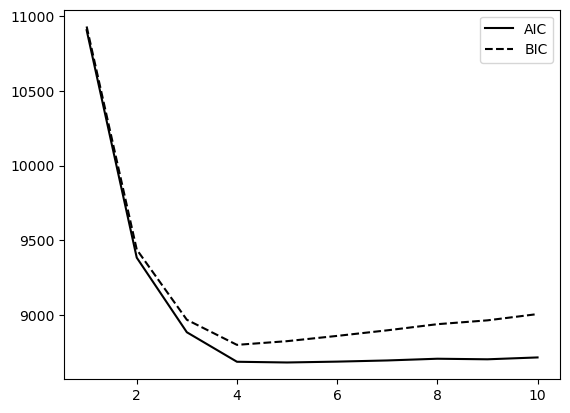

In [82]:
#4
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
print(N[np.argmin(BIC)],"Optimal components for BIC")
print(N[np.argmin(AIC)], "Optimal componenets for AIC")
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.legend()

In [83]:
K = [0,1,2,3]
M_best = models[np.argmin(BIC)]
logprob = M_best.score_samples(Xgrid)
responsibilities = M_best.predict_proba(Xgrid)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

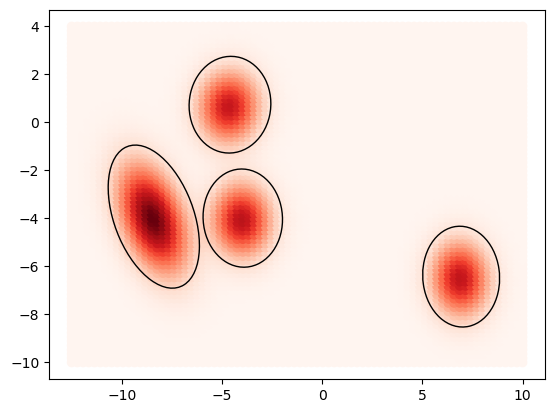

In [84]:
mu = M_best.means_
Con = M_best.covariances_
plt.scatter(Xgrid[:,0],Xgrid[:,1],c=pdf, cmap = 'Reds')
for a in K:
    draw_ellipse(mu[a],Con[a],[2])

In [85]:
K = [0,1,2,3,4]
M_best = models[np.argmin(AIC)]
logprob = M_best.score_samples(Xgrid)
responsibilities = M_best.predict_proba(Xgrid)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

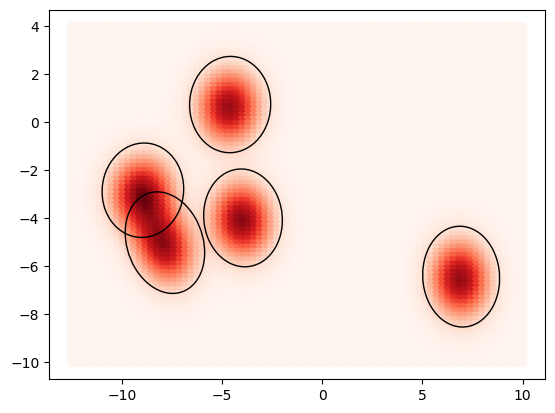

In [86]:
mu = M_best.means_
Con = M_best.covariances_
plt.scatter(Xgrid[:,0],Xgrid[:,1],c=pdf, cmap = 'Reds')
for a in K:
    draw_ellipse(mu[a],Con[a],[2])

In [87]:
#5
n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

KMeans(n_clusters=5)

[[-0.40764475 -0.5030598 ]
 [ 1.85376895 -1.41690679]
 [-0.16072001  1.62562286]
 [-0.76765014  0.28459509]
 [ 1.85702647 -0.7874329 ]]


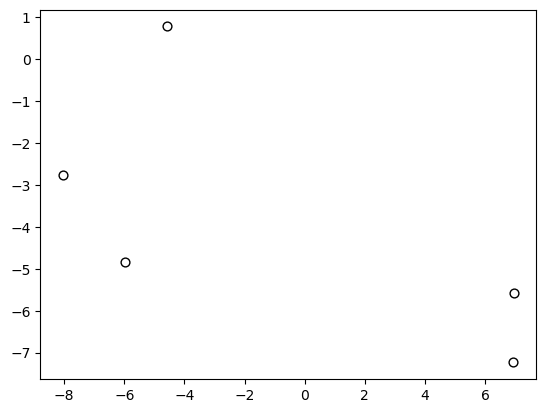

In [88]:
centers = clf.cluster_centers_
print(centers)
cluster_centers = scaler.inverse_transform(centers)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

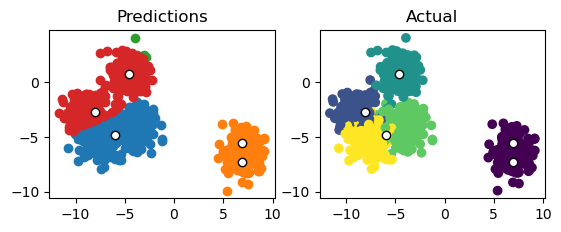

In [89]:
labels = clf.predict(X)
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
plt.subplot(2,2,1)
for i in range(5):
    plt.scatter(X[labels==i,0], X[labels==i,1], 
                color=colors[i])
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], edgecolors='k', c='w')
plt.title("Predictions")
plt.subplot(2,2,2)
plt.scatter(x,y, c = label)
plt.title("Actual")
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], edgecolors='k', c='w')